In [1]:
import pandas as pd
import numpy as np
import xlrd
from datetime import datetime

In [2]:
def clean_vic_df(age_file):
        
    df = pd.read_csv(f'sources/raw/{age_file}.csv')
    
    # drop unneeded columns
    df.drop(['Active_Cases', 'Daily_Recovered', 'Cases', 'Sex'], axis=1, inplace=True)

    # reorder columns
    df = df[['Date', 'agegroup', 'Cases_Male', 'Cases_Female']]

    # convert date strings to python datetime objects
    df['Date'] = pd.to_datetime(df['Date'])

    # retain only dates from 1/1/22 to 4/4/22
    start_date = datetime(2022, 1, 1)
    end_date = datetime(2022, 4, 8)

    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    # combine duplicate dates; add male and female cases
    df = df.groupby('Date').sum()
    df['Cases'] = df['Cases_Male'] + df['Cases_Female']

    # drop male and female cases; no longer needed
    df.drop(['Cases_Male', 'Cases_Female'], axis=1, inplace=True)
    
    df = df.astype("int")

    # rename column to age range
    df.columns = [age_file]
        
    return df

In [4]:
age_files = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

df_vic = pd.DataFrame()

for file in age_files:
    df_vic = pd.concat([df_vic, clean_vic_df(file)], axis=1)
      
df_vic.to_csv(f'sources/clean/vic.csv')     
        
print(f'Expected rows: 98 | Actual rows: {df_vic.shape[0]}')
df_vic.head()

Expected rows: 98 | Actual rows: 98


,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+
Date,,,,,,,,,,
2022-01-01,389,705,2784,1406,605,608,342,180,58,13
2022-01-02,459,828,3294,1682,800,743,395,174,88,19
2022-01-03,654,1470,5372,2626,1263,1274,640,261,134,32
2022-01-04,805,1992,7046,3025,1628,1421,793,301,98,33
2022-01-05,776,2676,9464,3827,1863,1715,878,342,96,26


In [5]:
# bring in qld cases

df_qld = pd.read_csv('sources/raw/qld_all_ages.csv')

# rename columns
df_qld.columns = ['date', 'age_group']

# convert date strings into datetime objects
df_qld['date'] = pd.to_datetime(df_qld['date'], infer_datetime_format=True)

# collect age groups belonging to each date
# add up age group totals for every day
# unstack - make age groups their own columns
df_qld = df_qld.groupby(['date']).value_counts().unstack()

# retain only dates from 1/1/22 to 4/4/22
start = datetime(2022, 1, 1)
end = datetime(2022, 4, 1)
df_qld = df_qld[start:end]

# create list of original age groups to drop later
orig_age_groups = df_qld.columns.to_list()

# replace NaN with 0
df_qld = df_qld.replace(np.nan, 0)

# combine age groups to match vic
df_qld['0-9'] = df_qld['00-04 years'] + df_qld['05-09 years']
df_qld['10-19'] = df_qld['10-14 years'] + df_qld['15-19 years']
df_qld['20-29'] = df_qld['20-24 years'] + df_qld['25-29 years']
df_qld['30-39'] = df_qld['30-34 years'] + df_qld['35-39 years']
df_qld['40-49'] = df_qld['40-44 years'] + df_qld['45-49 years']
df_qld['50-59'] = df_qld['50-54 years'] + df_qld['55-59 years']
df_qld['60-69'] = df_qld['60-64 years'] + df_qld['65-69 years']
df_qld['70-79'] = df_qld['70-74 years'] + df_qld['75-79 years']
df_qld['80-89'] = df_qld['80-84 years'] + df_qld['85-89 years']
df_qld['90+'] = df_qld['90-94 years'] + df_qld['95-99 years'] + df_qld['100+ years']

# drop original columns
df_qld.drop(orig_age_groups, axis=1, inplace=True)

# convert all to int
df_qld = df_qld.astype("int")

df_qld.to_csv(f'sources/clean/qld.csv')

df_qld.head()

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+
date,,,,,,,,,,
2022-01-01,206,490,1621,874,555,428,225,104,48,11
2022-01-02,241,744,2254,945,570,463,246,115,37,9
2022-01-03,331,1253,3882,1552,912,675,332,129,52,7
2022-01-04,379,1602,4982,2077,1112,848,373,130,57,14
2022-01-05,380,1686,5382,2208,1298,928,401,159,47,16


In [6]:
# bring in state populations by age

df_pop = pd.read_excel('sources/raw/abs.xls', sheet_name='Table 3')

# rename columns to more easily work with age groups
# first edit the column labels from qld as it's similar to the groupings the abs uses 
del orig_age_groups[18:21]
del orig_age_groups[3]
orig_age_groups.append('85+ years')

col_dict = {}
for i in range(10, 28):
    col_dict["Unnamed: " + str(i)] = orig_age_groups[i-10]  
    
df_pop.rename(columns=col_dict, inplace=True)

# combine age groups to match vic and qld
df_pop['0-9'] = df_pop['00-04 years'] + df_pop['05-09 years']
df_pop['10-19'] = df_pop['10-14 years'] + df_pop['15-19 years']
df_pop['20-29'] = df_pop['20-24 years'] + df_pop['25-29 years']
df_pop['30-39'] = df_pop['30-34 years'] + df_pop['35-39 years']
df_pop['40-49'] = df_pop['40-44 years'] + df_pop['45-49 years']
df_pop['50-59'] = df_pop['50-54 years'] + df_pop['55-59 years']
df_pop['60-69'] = df_pop['60-64 years'] + df_pop['65-69 years']
df_pop['70-79'] = df_pop['70-74 years'] + df_pop['75-79 years']
df_pop['80+'] = df_pop['80-84 years'] + df_pop['85+ years']

# rename column that contains headings for state totals
# drop unneeded column
df_pop.rename(columns = {'Unnamed: 1': 'state'}, inplace=True)

# drop original age groups and remaining "Unnamed" columns
keep_cols = [col for col in df_pop.columns if not(col.startswith('Unnamed') | col.endswith('years'))]
df_pop = df_pop[keep_cols]

# retain only the rows that contain state totals
def contains_total(x):
    if str(x).startswith('TOTAL'):
        return True
    else:
        return False
    
df_pop = df_pop[df_pop['state'].apply(contains_total)]
df_pop.dropna(axis=1, inplace=True)

# set index to state abbreviations for easier slicing etc
# then drop state column
df_pop.index = ['nsw', 'vic', 'qld', 'sa', 'wa', 'tas', 'nt', 'act']
df_pop.drop('state', axis=1, inplace=True)

df_pop.to_csv(f'sources/clean/population.csv')

df_pop

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
nsw,1007869,969431,1148124,1194414,1039901,979824,865363,608521,354085
vic,818646,774408,1006743,1029094,856568,792986,674706,467529,275990
qld,653849,664219,709292,716760,673211,638657,542431,382809,194958
sa,204463,207480,232170,234689,217189,226383,207487,151073,89441
wa,346736,325420,351572,402284,352179,330587,274502,181714,98567
tas,60984,64337,65756,65410,64257,72013,70868,50893,26262
nt,35566,32109,38125,44359,33704,29733,20204,9409,2934
act,56732,49882,66618,71088,59258,49276,38580,26368,13578


In [17]:
# Q1 What percentage of new cases at start of term were children? 
# and what percentage of new cases at end of term were children?

start = '2022-01-31'
end = '2022-04-08'

df_term = df_vic[start:end]

all_start = df_term.loc[start].sum()
child_start = df_term.loc[start, '0-9'] + df_term.loc[start, '10-19']
percent_start = round(child_start/all_start * 100)
print(all_start, child_start, percent_start)

all_end = df_term.loc[end].sum()
child_end = df_term.loc[end, '0-9'] + df_term.loc[end, '10-19']
percent_end = round(child_end/all_end * 100)
print(all_end, child_end, percent_end)

11106 3584 32
9348 2390 26


Age group with most cases throughout term: 10-19
Number of cases in 10-19 group: 113696


<AxesSubplot:>

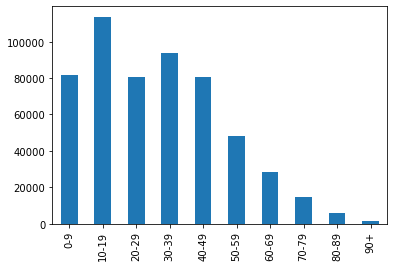

In [18]:
# Q2 Which age group had the most new cases throughout the term?
# answer: calc, illustrate with graph (bar)

age_group_max = df_term.sum().idxmax()
max_cases = df_term.sum().max()

print(f'Age group with most cases throughout term: {age_group_max}')
print(f'Number of cases in {age_group_max} group: {max_cases}')

df_term.sum().plot(kind='bar')

In [24]:
# Q3 How did case numbers compare to population proportion throughout term?
# ans graph1 showing ratio of cases to age group population, for all age groups
# ans graph2 showing % of cases above population % line, for just children

df_vic_pop = df_pop.loc['vic']
df_vic_ages = df_vic.columns
df_vic.columns

Index(['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79',
       '80-89', '90+'],
      dtype='object')